# $(\eta,\phi)$

**Goal:** Encode the $\eta$, $\phi$ translations naturally into the attention mechanism and the network

I'm hoping I can easily do as good as a simple feed forward MLP if I condition on the 4 jet mass, I think this would be a nice sanity check tbh.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob
import uproot
import json
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from itertools import combinations

import os
os.sys.path.append('../GraphNN/')
from trainNet import getGNNDataLoaders

%load_ext autoreload
%autoreload 2

**Step 1:** Load in some data set

Let's start w/ like the MDR + $\min D_{hh}$ dataset.

In [2]:
physicsSample = 'SMNR'
prodTag = 'APR2020'

In [3]:
# This corresponds to the 5 jets dataset

nSelectedJets = 5
batch_size=2048
loader_train, loader_val = getGNNDataLoaders(batch_size,nSelectedJets=nSelectedJets,prodTag=prodTag)

mask 262326
0
mask 262326
262326  train + val events


In [4]:
df = pd.read_hdf('../data/SMNR_mc16a_PFlow-APR2020/df_MDR_3b.h5')

In [5]:
df.head()

eventNumber  nresolvedJets  weight_pileup  mcEventWeight  rand_run_nr  \
entry                                                                          
3           286535              5       1.097209       0.031172       305543   
4           286990              7       1.182488       0.034985       279984   
7           285372              5       0.882703       0.031172       311365   
8           286268              8       0.874719       0.031172       306269   
9           286648              5       0.837192       0.031172       301973   

            j0_pt    j0_eta    j0_phi        j0_E  j0_Db  ...     w_k11  \
entry                                                     ...             
3      324.497467  1.056266 -2.457010  526.199890    5.0  ...  0.000584   
4      442.594788  0.842337  1.651080  609.308472    5.0  ...  0.000640   
7       90.420914 -0.478221  0.800705  101.461746    5.0  ...  0.002404   
8      183.636826  0.561266 -2.309647  213.605881    4.0  ...  0.001310   
9      103.905296  1.473665 -1.613765  238.963760    5.0  ...  0.003440   

          w_k12     w_k13     w_k14     w_k15     w_k16     w_k17     w_k18  \
entry                                                                         
3      0.000737  0.000912  0.001111  0.001333  0.001578  0.001846  0.002137   
4      0.000800  0.000985  0.001196  0.001432  0.001693  0.001979  0.002291   
7      0.003058  0.003791  0.004605  0.005498  0.006471  0.007525  0.008658   
8      0.001679  0.002097  0.002563  0.003078  0.003641  0.004252  0.004912   
9      0.004348  0.005362  0.006484  0.007713  0.009048  0.010491  0.012041   

          w_k19     w_k20  
entry                      
3      0.002452  0.002790  
4      0.002628  0.002990  
7      0.009871  0.011164  
8      0.005621  0.006378  
9      0.013697  0.015461  

[5 rows x 205 columns]

In [6]:
cols = [f'j{i}_{v}' for i in range(4) for v in ['eta','phi']]

# Shape nEvts, nJets, nVars
X = df[cols].values.reshape(-1,4,2)


Text(0.5, 0, 'eta')

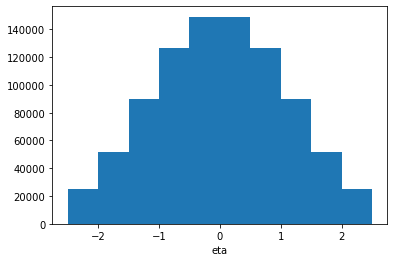

In [7]:
plt.hist(X[:,:,0].flatten())
plt.xlabel('eta')

Text(0.5, 0, 'phi')

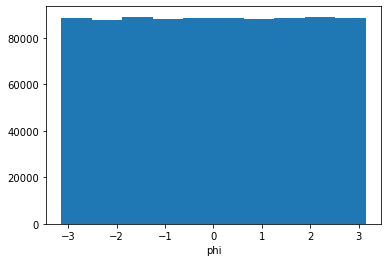

In [8]:
plt.hist(X[:,:,1].flatten())
plt.xlabel('phi')

In [9]:
X.shape

(221028, 4, 2)

In [10]:
y = df.correctPair.values

In [117]:
mb_size = 100

X_mb = torch.from_numpy(X[:100]).float()
y_mb = torch.from_numpy(y[:100]).long()

**Step 2:** Compute the vectors for the query, key, and value embeddings

So right now I'm just considering *one* attention head.

The equation I want to implement is

$$\alpha_{ij} = \frac{\exp(q_i^T k_{ij})}{\sum_{j' \in \mathcal{N_i} \backslash i}\exp(q_i^T k_{ij})}, \qquad q_i = W_{Q} f_{in,i} \qquad k_{ij} = W_K (x_j - x_i) f_{in,j}$$


Rn I think I've been considering 20 dim for the embedding dimension where the dot product is calculated (maybe I should double check this), although w/ 4 heads, it's kind of like four 5d compatibility maps.

**Let's consider the convolution operation on just the *first* jet.**

Retrieve the vector of displacements w/r.t. the other jets (used for the key and value embeddings)

In [118]:
X_mb

tensor([[[ 1.0563e+00, -2.4570e+00],
         [-5.6596e-02,  8.5460e-01],
         [ 1.5989e+00, -2.1015e+00],
         [ 5.3956e-01,  7.5589e-01]],

        [[ 8.4234e-01,  1.6511e+00],
         [ 3.9305e-01, -1.1371e+00],
         [ 1.1554e+00, -1.4466e+00],
         [-5.2286e-01, -2.0558e+00]],

        [[-4.7822e-01,  8.0070e-01],
         [ 7.7623e-01,  5.4179e-02],
         [ 1.6247e+00, -1.3327e+00],
         [ 1.2405e+00, -2.8198e+00]],

        [[ 5.6127e-01, -2.3096e+00],
         [ 7.0896e-01,  5.1213e-01],
         [ 1.4686e+00, -2.0970e+00],
         [-4.2563e-01,  4.8978e-01]],

        [[ 1.4737e+00, -1.6138e+00],
         [ 1.5064e+00, -2.0224e-01],
         [ 2.1631e+00, -3.1236e+00],
         [ 1.1207e+00,  2.0605e+00]],

        [[-2.6804e-01, -2.0285e+00],
         [-1.0592e+00, -1.3285e+00],
         [-3.6197e-01,  1.9287e+00],
         [-3.9355e-01,  9.7276e-01]],

        [[ 9.7251e-01,  2.8969e+00],
         [ 2.3648e+00,  2.6780e+00],
         [ 1.3935e+00,  9.

In [13]:
dx1 = X_mb - X_mb[:,0,:].reshape(-1,1,2)

dx1[:,:,1] = torch.acos(torch.cos(dx1[:,:,1]))

In [119]:
dx1.shape

torch.Size([100, 4, 2])

<function matplotlib.pyplot.show(*args, **kw)>

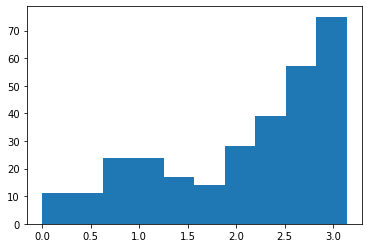

In [120]:
plt.hist(dx1[:,1:,1].flatten())
plt.show

Ok - I *thought* about it
, and I don't think I want value embedding.

**query embedding**

In [16]:
# embed_dim / 4

d_model = 5 

In [88]:
Wq = nn.Linear(2, d_model, bias = True)

Since the nn.Linear layer xforms the *last* dimension, it doesn't matter whether I permute the first 2 dims now or later (I think).

In [19]:
dx1.float()

tensor([[[ 0.0000e+00,  0.0000e+00],
         [-1.1129e+00,  2.9716e+00],
         [ 5.4260e-01,  3.5555e-01],
         [-5.1670e-01,  3.0703e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [-4.4929e-01,  2.7882e+00],
         [ 3.1307e-01,  3.0977e+00],
         [-1.3652e+00,  2.5763e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 1.2545e+00,  7.4653e-01],
         [ 2.1029e+00,  2.1334e+00],
         [ 1.7187e+00,  2.6626e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 1.4769e-01,  2.8218e+00],
         [ 9.0737e-01,  2.1262e-01],
         [-9.8690e-01,  2.7994e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 3.2753e-02,  1.4115e+00],
         [ 6.8940e-01,  1.5098e+00],
         [-3.5292e-01,  2.6090e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [-7.9118e-01,  7.0003e-01],
         [-9.3927e-02,  2.3260e+00],
         [-1.2551e-01,  3.0013e+00]],

        [[ 0.0000e+00,  0.0000e+00],
         [ 1.3923e+00,  2.1880e-01],
         [ 4.2094e-01,  1.

In [37]:
#Wq1 = Wq_fct(dx1)

In [38]:
#Wq1.shape

In [22]:
x1 = X_mb[:,0,:]
x1[:,-1] = torch.cos(x1[:,-1])
x1.shape

torch.Size([100, 2])

In [89]:
q = Wq(x1)

q.shape

torch.Size([100, 5])

In [113]:
q_all = Wq(x)

In [114]:
q_all.shape

torch.Size([100, 4, 5])

In [115]:
q[0]

tensor([1.1408, 0.4990, 0.0917, 0.3288, 0.5509], grad_fn=<SelectBackward>)

In [116]:
q_all[0,0]

tensor([1.1408, 0.4990, 0.0917, 0.3288, 0.5509], grad_fn=<SelectBackward>)

Side note - I'm not sure if I want to include the bias here (in the q calc) or above in the Wq1_fct calculation, or *both*

In [87]:
# out = hypernet_q(dx1)

# out.shape

# Wq1 = out[:,:,:d_model*2].view(-1,4,d_model,2)
# bq1 = out[:,:,d_model*2:]#.view(-1,1,d_model)

# Wq1.shape

# bq1.shape

# x1.unsqueeze(1).unsqueeze(-1).shape

# q = torch.matmul(Wq1,x1.unsqueeze(1).unsqueeze(-1)).squeeze() + bq1

# q.shape

In [69]:
q[0]

tensor([[-0.0148, -0.0171,  0.5277,  0.1216,  0.4666],
        [-0.5426, -0.8233,  0.5167,  0.1763, -0.4210],
        [-0.0438,  0.0694,  0.7375,  0.3601,  0.7087],
        [-0.4503, -0.7062,  0.7068,  0.5477, -0.3704]],
       grad_fn=<SelectBackward>)

In [70]:
D_in = 2
D_out = d_model*(D_in+1)

H = 20

hypernet_k = torch.nn.Sequential(
                    torch.nn.Linear(D_in, H),
                    torch.nn.ReLU(),
                    torch.nn.Linear(H, D_out),
                   )



In [227]:
kout1 = hypernet_k(dx1)

In [72]:
Wk1 = kout1[:,:,:d_model*2].view(-1,4,d_model,2)
bk1 = kout1[:,:,d_model*2:]

In [75]:
x = X_mb
x[:,:,-1] = torch.cos(x[:,:,-1])

In [79]:
x.shape

torch.Size([100, 4, 2])

In [170]:
k1 = torch.matmul(Wk1,x.unsqueeze(-1)).squeeze() + bk1

k1.shape

torch.Size([100, 4, 5])

**Step 3:** Stitch this together into an attention mechanism

In [171]:
num1 = torch.exp(torch.matmul(k1,q.unsqueeze(-1)).squeeze())
num1.shape

torch.Size([100, 4])

In [172]:
# Recall - this term *doesn't* include the self-interactions

den1 = num1[:,1:].sum(axis=1)

In [173]:
alpha1s = num1 / den1.view(-1,1)

**Midplay summary:** Cool, I now *have* the attention weights... so let's *sum* over them and see how we want to *update* the corresponding nodes.


For the *self-interactions*, I think rn I don't want to upate these.

In [110]:
x1_new = x1 + torch.sum(alphas[:,1:].unsqueeze(-1) * x[:,1:],axis=1)

In [106]:
x1.shape

torch.Size([100, 2])

In [107]:
alphas.shape

torch.Size([100, 4])

In [109]:
x.shape

torch.Size([100, 4, 2])

In [111]:
x1[0]

tensor([1.0563, 0.7146])

In [112]:
x1_new[0]

tensor([1.7798, 0.9656], grad_fn=<SelectBackward>)

OK - cool!!! But ofc I'll want to *vectorize* this over the relevant operations... what steps are necessary for this?


I think the biggest logic is for the **key embedding**.

In [122]:
# J a little reminder...

# dx1 = X_mb - X_mb[:,0,:].reshape(-1,1,2)
# dx1[:,:,1] = torch.acos(torch.cos(dx1[:,:,1]))

In [232]:
# xj (source) - xi (target)
dx = X_mb.view(-1,1,4,2) - X_mb.view(-1,4,1,2)

dx[:,:,:,-1] = torch.acos(torch.cos(dx[:,:,:,-1]))

In [233]:
kout = hypernet_k(dx)
kout.shape

torch.Size([100, 4, 4, 15])

In [235]:
Wk = kout[:,:,:,:d_model*2].view(-1,4,4,d_model,2)
bk = kout[:,:,:,d_model*2:]

In [236]:
k = torch.matmul(Wk,x.unsqueeze(1).unsqueeze(-1)).squeeze() + bk

k.shape

torch.Size([100, 4, 4, 5])

Next - let's implement the dot product attention mechanism b/w the key and query points

In [136]:
x.shape

torch.Size([100, 4, 2])

In [239]:
# Also - we only want to consider the *non-diagonal* entries here
mask = (~ torch.eye(4).bool()).float().view(1,4,4,1)

num = torch.exp(torch.matmul(k,q_all.unsqueeze(-1))) * mask
num.shape

torch.Size([100, 4, 4, 1])

In [240]:
torch.matmul(k.view(-1,4,5),q_all.view(-1,5,1)).view(100,4,4)[0]

tensor([[-0.5425, -1.0676, -1.0006, -1.2332],
        [-1.2753, -0.8467, -1.3482, -0.6037],
        [-0.3993, -0.5480, -0.7382, -0.6630],
        [-1.3535, -0.7401, -1.6442, -0.6160]], grad_fn=<SelectBackward>)

In [241]:
torch.matmul(k,q_all.unsqueeze(-1)).squeeze()[0]

tensor([[-0.5425, -1.0676, -1.0006, -1.2332],
        [-1.2753, -0.8467, -1.3482, -0.6037],
        [-0.3993, -0.5480, -0.7382, -0.6630],
        [-1.3535, -0.7401, -1.6442, -0.6160]], grad_fn=<SelectBackward>)

In [183]:
torch.matmul(k1,q.unsqueeze(-1)).squeeze()[0]

tensor([-0.5425, -1.0676, -1.0006, -1.2332], grad_fn=<SelectBackward>)

Could smth have gotten fucked in the k and q_all definitions?

In [204]:
torch.matmul(k[:,0],q.unsqueeze(-1)).squeeze()[0]

tensor([-0.5425, -1.2377, -0.3929, -1.3235], grad_fn=<SelectBackward>)

In [242]:
den = torch.sum(num,dim=2,keepdim=True)

alphas = num / den

In [161]:
x.unsqueeze(1).shape

torch.Size([100, 1, 4, 2])

In [245]:
x_new = x + torch.sum(alphas * x.unsqueeze(1), 2)

In [164]:
x_new.shape

torch.Size([100, 4, 2])

In [246]:
x1_new[0]

tensor([1.7798, 0.9656], grad_fn=<SelectBackward>)

In [247]:
x_new[0]

tensor([[1.7798, 0.9656],
        [0.8693, 1.0857],
        [2.1396, 0.1933],
        [1.1369, 1.1585]], grad_fn=<SelectBackward>)

Perfect, so it's definitely working now (lol), maybe the next step is to try to turn this into a dedicated pytorch layer?

**Reminder: args for MultiheadAttention**

`self,embed_dim, num_heads=1, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None`

In [321]:
class EquivariantSelfAttn(nn.Module):
    '''
    '''
    
    
    def __init__(self,embed_dim=5, H=20):
        '''
        
        Ok - I might need to see which ... I want to
        
        '''
        super(EquivariantSelfAttn, self).__init__()


#         assert num_heads == 1
#         assert dropout == 0
        
        
        self.embed_dim = embed_dim
        self.njets = 4
        self.D_in = 2
        
        D_out = embed_dim * (self.D_in+1)
        self.hypernet_k = torch.nn.Sequential(
                                torch.nn.Linear(self.D_in, H),
                                torch.nn.ReLU(),
                                torch.nn.Linear(H, D_out)
                               )

        self.Wq = nn.Linear(self.D_in, self.embed_dim, bias = True)
        
        self.mask = (~ torch.eye(self.njets).bool()).float().view(1,self.njets,self.njets,1)
        
        
    def forward(self,x):
        '''
        
        Inputs:
        - x: has shape (nEvts,nJets=4,nFeatures=2)
        
        '''
        
        # Get the matrix of internodal distances: xj (source) - xi (target)
        dx = x.view(-1,1,self.njets,self.D_in) - x.view(-1,self.njets,1,self.D_in)
        dx[:,:,:,-1] = torch.acos(torch.cos(dx[:,:,:,-1]))
        
        # Now calculate the key embeddings
        kout = self.hypernet_k(dx)
        n = self.embed_dim*self.D_in
        Wk = kout[:,:,:,:n].view(-1, self.njets, self.njets, self.embed_dim, self.D_in)
        bk = kout[:,:,:,n:]
        
        k = torch.matmul(Wk,x.unsqueeze(1).unsqueeze(-1)).squeeze() + bk
        
        # Calculate the query embeddings
        x_in = torch.cat([x[:,:,0].unsqueeze(-1),torch.cos(x[:,:,1].unsqueeze(-1))],dim=-1)
        q = self.Wq(x_in)
        
        num = torch.exp(torch.matmul(k, q.unsqueeze(-1))) * self.mask
        den = torch.sum(num,dim=2,keepdim=True)
        alphas = num / den
        
        x_new = x + torch.sum(alphas * x.unsqueeze(1), 2)
        
        # Should I take care of the phi boundedness here?
        
        return x_new, alphas.squeeze()

In [325]:
class testAttn(nn.Module):
    
    def __init__(self, inpt_dim=2, embed_dim=20, nHeads=4, njets=4):
        '''
        Just use a (couple) layers of an attention mechansim, b/c I'm not sure if all the bells
        and whistles of the transformer models was necessary - or if this was just *complicating*
        matters.
        
        Inputs:    
        - in_dim: # of features used to repn each jet
        - embed_dim: size of the latent space representing the jets
        - nAttnBlocks: # of attn blocks to use before classifying 
                       the edges
        - nHeads:
        - p: dropout fraction
        - njets: Max # of jets to include

        '''
        super(testAttn, self).__init__()
    
        self.attnLayer = EquivariantSelfAttn(embed_dim) # , num_heads=nHeads)
        
        self.embed_dim = embed_dim
        self.njets = njets
    
        self.score = lambda e: \
                torch.cat([(e[:,i11,i12] + e[:,i12,i21] + e[:,i21,i22] + e[:,i22,i21]).view(-1,1)  
                          for i0,i1,i2,i3 in combinations(range(self.njets),4) \
                          for (i11,i12), (i21, i22) in zip([(i0,i1),(i0,i2),(i0,i3)],[(i2,i3),(i1,i3),(i1,i2)])],axis=1)

    def forward(self, x):
        '''
        Inputs:
        - x has shape (batchSize, nJets, nFeatures)
        '''
        self.njets = x.shape[1]

        _, e = self.attnLayer(x)       
        score = self.score(e)
        
        return score, e

In [328]:
m = testAttn(2,5,1)

In [330]:
score, edges = m(x)

In [287]:
y_pred = np.argmax(score.detach().numpy(),axis=1)

In [291]:
np.unique(y_pred,return_counts=True)

(array([0, 1, 2]), array([42, 30, 28]))

**Next:** verify the predictions are indeed equivariant (or - I think here invariant?) w/r.t. the xformations of the input dataset.

In [303]:
X_mb[0]

tensor([[ 1.0563, -2.4570],
        [-0.0566,  0.8546],
        [ 1.5989, -2.1015],
        [ 0.5396,  0.7559]])

In [301]:
# Rotate by pi / 8
xi = X_mb + 2 * np.pi / K
xi = torch.where(xi>np.pi, xi-2*np.pi, xi)
xi = torch.where(xi<-np.pi, xi+2*np.pi, xi)

In [304]:
xi[0]

tensor([[ 1.4490, -2.0643],
        [ 0.3361,  1.2473],
        [ 1.9916, -1.7088],
        [ 0.9323,  1.1486]])

In [344]:
equivLayer = EquivariantSelfAttn()

y, e = equivLayer(X_mb)

In [336]:
yi, ei = equivLayer(xi)

In [337]:
ei[0]

tensor([[0.0000, 0.1536, 0.4761, 0.3703],
        [0.3789, 0.0000, 0.5114, 0.1097],
        [0.1997, 0.1641, 0.0000, 0.6361],
        [0.3707, 0.0053, 0.6239, 0.0000]], grad_fn=<SelectBackward>)

In [338]:
e[0]

tensor([[0.0000, 0.0432, 0.9023, 0.0544],
        [0.2585, 0.0000, 0.5467, 0.1948],
        [0.6611, 0.0793, 0.0000, 0.2596],
        [0.1317, 0.0843, 0.7840, 0.0000]], grad_fn=<SelectBackward>)

In [347]:
y[0].detach(), yi[0].detach() #+ np.pi / 8

(tensor([[ 1.5652, -1.8479],
         [ 0.9401,  0.0545],
         [ 2.1090, -1.5103],
         [ 1.3087, -0.0733]]),
 tensor([[ 2.7940, -2.2610],
         [ 2.0059, -0.2827],
         [ 2.9292, -1.1857],
         [ 2.7138, -0.6762]]))

**Q:** Is this it, or do I need to take care of something else before training?

**Bells and whistles to add:**
1. Multihead attention
2. Masking over jets
3. Layer norm (pre and post options?)
4. Dropout
